COVID/images 文件夹: 找到 3616 张图像
Normal/images 文件夹: 找到 10192 张图像
Viral Pneumonia/images 文件夹: 找到 1345 张图像
Lung_Opacity/images 文件夹: 找到 6012 张图像
总共找到 21165 张图像
Epoch 1/10


100%|██████████| 662/662 [00:28<00:00, 23.20it/s]


Generator Loss: 4.6558  Discriminator Loss: 0.1973


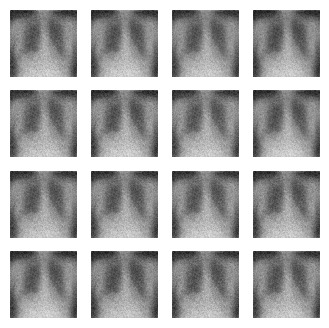

Epoch 2/10


100%|██████████| 662/662 [00:26<00:00, 25.08it/s]


Generator Loss: 6.4897  Discriminator Loss: 0.2422


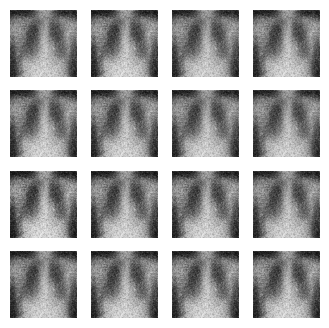

Epoch 3/10


100%|██████████| 662/662 [00:26<00:00, 25.16it/s]


Generator Loss: 8.5418  Discriminator Loss: 0.3824


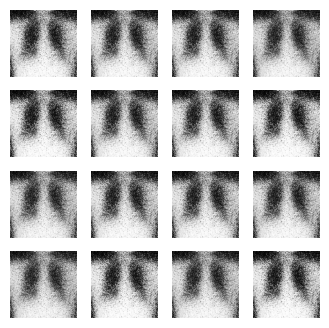

Epoch 4/10


100%|██████████| 662/662 [00:26<00:00, 25.04it/s]


Generator Loss: 9.6354  Discriminator Loss: 0.4311


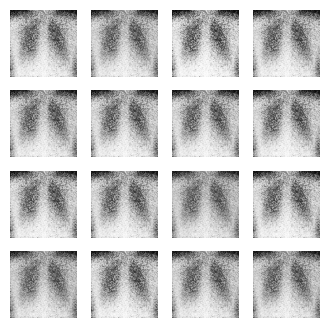

Epoch 5/10


100%|██████████| 662/662 [00:25<00:00, 25.74it/s]


Generator Loss: 7.7525  Discriminator Loss: 0.3852


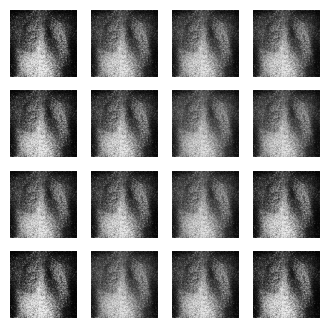

Epoch 6/10


100%|██████████| 662/662 [00:25<00:00, 25.78it/s]


Generator Loss: 7.0770  Discriminator Loss: 0.3162


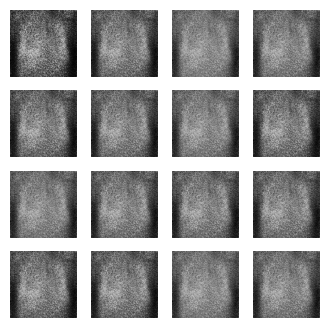

Epoch 7/10


100%|██████████| 662/662 [00:25<00:00, 25.64it/s]


Generator Loss: 4.7232  Discriminator Loss: 0.2675


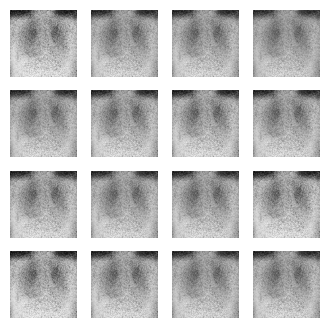

Epoch 8/10


100%|██████████| 662/662 [00:26<00:00, 25.35it/s]


Generator Loss: 4.2566  Discriminator Loss: 0.1998


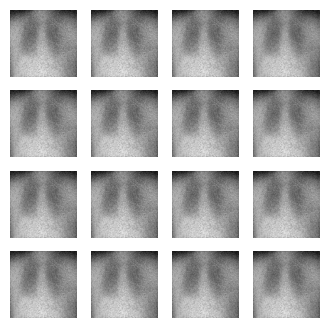

Epoch 9/10


100%|██████████| 662/662 [00:26<00:00, 25.20it/s]


Generator Loss: 4.2794  Discriminator Loss: 0.2107


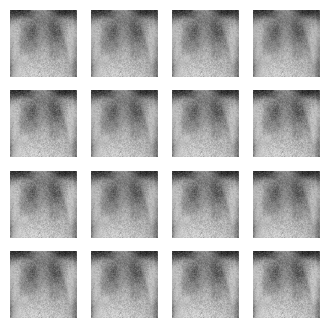

Epoch 10/10


100%|██████████| 662/662 [00:25<00:00, 25.55it/s]


Generator Loss: 4.6795  Discriminator Loss: 0.1860


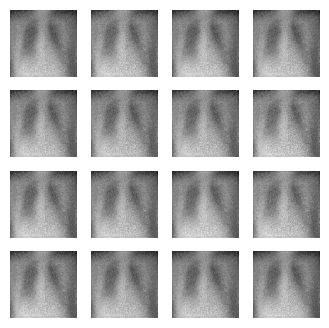

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
import warnings
warnings.filterwarnings("ignore")

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
NOISE_DIM = 100
DATA_DIR = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

def load_images(data_dir):
    categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
    image_paths = []
    for category in categories:
        category_folder = os.path.join(data_dir, category, 'images')
        images = glob(os.path.join(category_folder, '*.png'))
        image_paths.extend(images)
        print(f"{category}/images 文件夹: 找到 {len(images)} 张图像")
    print(f"总共找到 {len(image_paths)} 张图像")
    return image_paths

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return (image - 127.5) / 127.5

image_paths = load_images(DATA_DIR)
dataset = (tf.data.Dataset.from_tensor_slices(image_paths)
           .map(lambda x: preprocess_image(x))
           .batch(BATCH_SIZE)
           .shuffle(buffer_size=1000))

def build_generator():
    model = models.Sequential([
        layers.Dense(256, input_shape=(NOISE_DIM,), activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(IMG_SIZE * IMG_SIZE, activation='tanh'),
        layers.Reshape((IMG_SIZE, IMG_SIZE, 1))
    ])
    return model

def build_discriminator():
    model = models.Sequential([
        layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1)
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss = (loss_fn(tf.ones_like(real_output), real_output) +
                     loss_fn(tf.zeros_like(fake_output), fake_output))

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(epoch):
    noise = tf.random.normal([16, NOISE_DIM])
    fake_images = generator(noise, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f"epoch_{epoch:04d}_generated.png")
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        gen_losses = []
        disc_losses = []
        for image_batch in tqdm(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"Generator Loss: {np.mean(gen_losses):.4f}  Discriminator Loss: {np.mean(disc_losses):.4f}")

        generate_and_save_images(epoch + 1)

train(dataset, EPOCHS)
